# 線性判別分析(Linear Discriminant Analysis)

屬於「監督式學習」的方法來做降維，會根據「反應變數」的類別來做學習。投影到特徵向量的資料點，「類別內」的離散程度要最小，也就是變異量要小；而「類別間」的離散程度要大，也就是變異量要大。如此就可以依據不同類別的學習，得到一個依據類別分類的特徵向量。藉此方法所獲得的「新坐標系」在為「分類模型」尋找「決策邊界」時更有用，非常適合建構分類管線。

__LDA的步驟__
1. 計算每個類別的平均值向量(mean vectors)
2. 計算「類別內」與「類別間」的散佈矩陣(scatter matrix)
3. 計算S_W^(-1) S_B的「特徵值」和「特徵向量」
4. 降冪排列「特徵值」，保留「前k個特徵向量」
5. 使用「前幾個特徵向量」將資料投影到新空間

In [1]:
#載入資料
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
iris = load_iris()
print(iris.feature_names)
print(iris.target_names)

#建立特徵與反應變數
iris_X, iris_y = iris.data, iris.target

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


In [3]:
import numpy as np

## 1.計算每個類別的平均值向量(mean vectors)

In [4]:
#建立依照類別index的dict，dict = {index:'花名'}
label_dict = {i: k for i, k in enumerate(iris.target_names)}

In [5]:
#將資料分成三種區塊，每一個區塊都代表著一種鳶尾花的類別

mean_vectors = []
for cl in [0, 1, 2]:
    
    #每一種花種類的各個特徵平均值
    class_mean_vector = np.mean(iris_X[iris_y==cl], axis=0)
    
    mean_vectors.append(class_mean_vector)
    print(label_dict[cl], class_mean_vector)
    
print(mean_vectors)

setosa [5.006 3.428 1.462 0.246]
versicolor [5.936 2.77  4.26  1.326]
virginica [6.588 2.974 5.552 2.026]
[array([5.006, 3.428, 1.462, 0.246]), array([5.936, 2.77 , 4.26 , 1.326]), array([6.588, 2.974, 5.552, 2.026])]


## 2.計算「類別內」與「類別間」的散佈矩陣(scatter matrix)

### 類別內散佈矩陣(a within-class scatter matrix)

假設計算的是setosa種類的鳶尾花，是此種鳶尾花的資料的每一筆資料的各個特徵都會減掉該種類該特徵的平均值

In [6]:
S_W = np.zeros((4,4))

#對於每一種鳶尾花
for cl, mv in zip([0, 1, 2], mean_vectors):
    
    #從0開始，每個類別的散佈矩陣
    class_sc_mat = np.zeros((4,4))
    
    #對於每個樣本
    for row in iris_X[iris_y==cl]:
        
        #行向量，轉換成可以相乘的格式
        row, mv = row.reshape(4,1), mv.reshape(4,1)
        #4 X 4的矩陣
        class_sc_mat += (row-mv).dot((row-mv).T)
        
    S_W += class_sc_mat
    
S_W

array([[38.9562, 13.63  , 24.6246,  5.645 ],
       [13.63  , 16.962 ,  8.1208,  4.8084],
       [24.6246,  8.1208, 27.2226,  6.2718],
       [ 5.645 ,  4.8084,  6.2718,  6.1566]])

### 類別間的散佈矩陣(a between-class scatter matrix)

每個類別的樣本平均值減掉總體平均值

In [7]:
#計算總體平均值
overall_mean = np.mean(iris_X, axis=0).reshape(4,1)
overall_mean

array([[5.84333333],
       [3.05733333],
       [3.758     ],
       [1.19933333]])

In [8]:
S_B = np.zeros((4,4))
for i, mean_vec in enumerate(mean_vectors):
    #計算每一種花類別的數量
    n = iris_X[iris_y==i,:].shape[0]
    
    #每一種花的行向量
    mean_vec = mean_vec.reshape(4,1)
    
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
    
S_B

array([[ 63.21213333, -19.95266667, 165.2484    ,  71.27933333],
       [-19.95266667,  11.34493333, -57.2396    , -22.93266667],
       [165.2484    , -57.2396    , 437.1028    , 186.774     ],
       [ 71.27933333, -22.93266667, 186.774     ,  80.41333333]])

## 3.計算S_W^(-1) S_B的「特徵值」和「特徵向量」

In [9]:
#計算矩陣的特徵值和特徵向量
eig_vals, eig_vecs = np.linalg.eig(np.dot(np.linalg.inv(S_W), S_B))
eig_vecs = eig_vecs.real
eig_vals = eig_vals.real

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:, i]
    print('Eigenvector {}: {}'.format(i+1, eigvec_sc))
    print('Eigenvalue {:}: {}'.format(i+1, eig_vals[i]))
    print()

Eigenvector 1: [ 0.20874182  0.38620369 -0.55401172 -0.7073504 ]
Eigenvalue 1: 32.19192919827803

Eigenvector 2: [-0.00653196 -0.58661055  0.25256154 -0.76945309]
Eigenvalue 2: 0.28539104262306414

Eigenvector 3: [ 0.88513899 -0.29455053 -0.27255052 -0.23555291]
Eigenvalue 3: 3.5296362660244315e-15

Eigenvector 4: [-0.80593687  0.40432808  0.41273963 -0.12895956]
Eigenvalue 4: 3.17116800810927e-17



> 可以注意到第三個和第四個的特徵值__幾乎為0__，是因為LDA是依照「類別間」來劃分「決策邊界」。此資料集只有3個類別，所以只需要2個決策邊界就可以劃分。一般來說，用LDA擬合n個類別的資料集，最多需要n-1次切割。

## 4.降冪排列特徵值，保留前k個特徵向量

In [10]:
#保留兩個最好的線性判別式
linear_discriminants = eig_vecs.T[:2]
linear_discriminants

array([[ 0.20874182,  0.38620369, -0.55401172, -0.7073504 ],
       [-0.00653196, -0.58661055,  0.25256154, -0.76945309]])

In [11]:
#計算每個判別式解釋總變異數的比例
eig_vals / eig_vals.sum()

array([9.91212605e-01, 8.78739503e-03, 1.08680034e-16, 9.76425390e-19])

> 「第一個判別式」就做了絕大部分的工作，擁有超過99%的資訊

## 5.使用「前幾個特徵向量」將資料投影到新空間

In [12]:
#LDA投影資料
lda_iris_projection = np.dot(iris_X, linear_discriminants.T)
lda_iris_projection[:5,]

array([[ 1.49920971, -1.88675441],
       [ 1.2643595 , -1.59214275],
       [ 1.35525305, -1.73341462],
       [ 1.18495616, -1.62358806],
       [ 1.5169559 , -1.94476227]])

In [13]:
#繪圖function
def plot(X, y, title, x_label, y_label):
    ax = plt.subplot(111)
    
    for label, marker, color in zip(range(3), ('^', 's', 'o'), ('blue', 'red', 'green')):
        plt.scatter(x=X[:, 0].real[y == label],
                   y=X[:,1].real[y == label],
                   color=color,
                   alpha=0.5,
                   label=label_dict[label])
        
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        
        leg = plt.legend(loc='upper right', fancybox=True)
        leg.get_frame().set_alpha(0.5)
        plt.title(title)

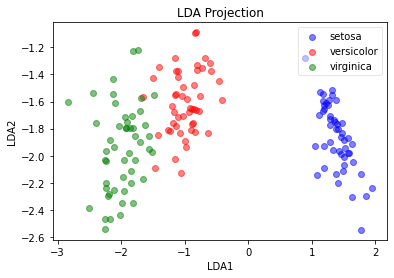

In [14]:
plot(lda_iris_projection, iris_y, "LDA Projection", "LDA1", "LDA2")

## scikit-learn中使用LDA
與PCA不同，LDA是依照反應變數去做降為，所以在fit時需要輸入反應變數

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [16]:
lda = LinearDiscriminantAnalysis(n_components=2)

In [17]:
X_lda_iris = lda.fit_transform(iris_X, iris_y)

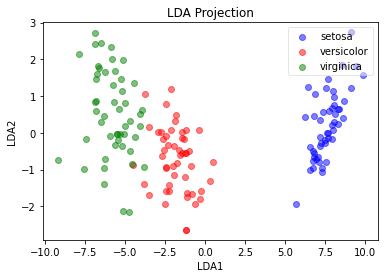

In [18]:
#繪製投影資料
plot(X_lda_iris, iris_y, "LDA Projection", "LDA1", "LDA2")

In [19]:
#lda的scalings_與pca的components_一樣，都是看特徵向量
lda.scalings_

array([[ 0.82937764,  0.02410215],
       [ 1.53447307,  2.16452123],
       [-2.20121166, -0.93192121],
       [-2.81046031,  2.83918785]])

In [20]:
#觀察特徵值
lda.explained_variance_ratio_

array([0.9912126, 0.0087874])